This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [3]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [4]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [5]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [6]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


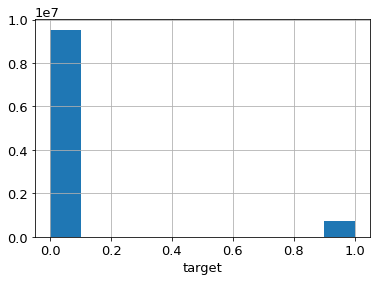

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['id_pair'] = train[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['id_pair'] = test[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,id_pair
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(E_1104d3664585a4, E_be8ec27bf1b71b)"
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(E_1514d74b987ae1, E_dfa69a18228406)"
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(E_206f06060f193d, E_bb40eb6b8aa6c9)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(E_20b7920b07557d, E_9acdcda349c154)"
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(E_4a34a5012e88c3, E_bc8a2b3674875b)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "id_pair"]]
test = test[features + ["id", "near_id", "id_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["id_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "id_pair"], train.loc[val_ind, "id_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,93.02%,6.98%
development set - fold 0,93.02%,6.98%
validation set - fold 0,93.02%,6.98%
development set - fold 1,93.02%,6.98%
validation set - fold 1,93.02%,6.98%
development set - fold 2,93.02%,6.98%
validation set - fold 2,93.02%,6.98%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.085434
[100]	valid_0's binary_logloss: 0.0824052
[150]	valid_0's binary_logloss: 0.0808705
[200]	valid_0's binary_logloss: 0.0799468
[250]	valid_0's binary_logloss: 0.0792634
[300]	valid_0's binary_logloss: 0.078772
[350]	valid_0's binary_logloss: 0.0783731
[400]	valid_0's binary_logloss: 0.0779851
[450]	valid_0's binary_logloss: 0.0776662
[500]	valid_0's binary_logloss: 0.0773929
[550]	valid_0's binary_logloss: 0.0771929
[600]	valid_0's binary_logloss: 0.0769773
[650]	valid_0's binary_logloss: 0.0767575
[700]	valid_0's binary_logloss: 0.0765685
[750]	valid_0's binary_logloss: 0.0763865
[800]	valid_0's binary_logloss: 0.0762307
[850]	valid_0's binary_logloss: 0.076075
[900]	valid_0's binary_logloss: 0.0759652
[950]	valid_0's binary_logloss: 0.0758554
[1000]	valid_0's binary_logloss: 0.0757092
[1050]	valid_0's binary_logloss: 0.0755778
[1100]	valid_0's binary_logloss: 0.0754711
[1150]	valid_0's binary_logloss: 0.0754083
[1200]	valid_0's bina

In [ ]:
train["pred"] = oof[:, -1]

In [ ]:
train["max_pred"] = train["id"].map(dict(train.groupby("id")["pred"].max()))

# Check CV

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 15:59:41,441] A new study created in memory with name: no-name-4c638b33-2a3e-4188-985c-1e5e1a958a0d
[I 2022-05-14 15:59:57,874] Trial 0 finished with value: 0.7957933438591689 and parameters: {'threshold': 0.7330828888497423}. Best is trial 0 with value: 0.7957933438591689.


CV: 0.795793, precision: 0.987686, recall: 0.805859


[I 2022-05-14 16:00:13,669] Trial 1 finished with value: 0.7983419376345368 and parameters: {'threshold': 0.7004832666954259}. Best is trial 1 with value: 0.7983419376345368.


CV: 0.798342, precision: 0.986021, recall: 0.809786


[I 2022-05-14 16:00:37,530] Trial 2 finished with value: 0.7472778055098523 and parameters: {'threshold': 0.03087164652502683}. Best is trial 1 with value: 0.7983419376345368.


CV: 0.747278, precision: 0.862337, recall: 0.855297


[I 2022-05-14 16:00:54,882] Trial 3 finished with value: 0.8043700795832727 and parameters: {'threshold': 0.5787618629099397}. Best is trial 3 with value: 0.8043700795832727.


CV: 0.804370, precision: 0.978926, recall: 0.821729


[I 2022-05-14 16:01:09,628] Trial 4 finished with value: 0.7976336997436707 and parameters: {'threshold': 0.7101478614062515}. Best is trial 3 with value: 0.8043700795832727.


CV: 0.797634, precision: 0.986519, recall: 0.808661


[I 2022-05-14 16:01:27,376] Trial 5 finished with value: 0.8054949733721684 and parameters: {'threshold': 0.5324108500477062}. Best is trial 5 with value: 0.8054949733721684.


CV: 0.805495, precision: 0.975807, recall: 0.825475


[I 2022-05-14 16:01:40,657] Trial 6 finished with value: 0.7778113698604112 and parameters: {'threshold': 0.8662009950350369}. Best is trial 5 with value: 0.8054949733721684.


CV: 0.777811, precision: 0.993864, recall: 0.782784


[I 2022-05-14 16:01:55,850] Trial 7 finished with value: 0.7931767052264953 and parameters: {'threshold': 0.7622601074606843}. Best is trial 5 with value: 0.8054949733721684.


CV: 0.793177, precision: 0.989125, recall: 0.802056


[I 2022-05-14 16:02:10,608] Trial 8 finished with value: 0.7836970979882174 and parameters: {'threshold': 0.8352637048973857}. Best is trial 5 with value: 0.8054949733721684.


CV: 0.783697, precision: 0.992488, recall: 0.789799


[I 2022-05-14 16:02:28,629] Trial 9 finished with value: 0.8061591833667386 and parameters: {'threshold': 0.43735156236069583}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.806159, precision: 0.968510, recall: 0.832236


[I 2022-05-14 16:02:48,967] Trial 10 finished with value: 0.7996492970500526 and parameters: {'threshold': 0.2426901903132238}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.799649, precision: 0.946568, recall: 0.843763


[I 2022-05-14 16:03:07,126] Trial 11 finished with value: 0.805587399173714 and parameters: {'threshold': 0.3796245624634996}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.805587, precision: 0.963349, recall: 0.835948


[I 2022-05-14 16:03:25,707] Trial 12 finished with value: 0.8041802908000751 and parameters: {'threshold': 0.32870972094730466}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.804180, precision: 0.957987, recall: 0.838956


[I 2022-05-14 16:03:44,360] Trial 13 finished with value: 0.8032035360520807 and parameters: {'threshold': 0.3033945253960505}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.803204, precision: 0.955045, recall: 0.840391


[I 2022-05-14 16:04:02,226] Trial 14 finished with value: 0.806060858941788 and parameters: {'threshold': 0.4247955124133136}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.806061, precision: 0.967409, recall: 0.833051


[I 2022-05-14 16:04:23,940] Trial 15 finished with value: 0.7892103635623198 and parameters: {'threshold': 0.14756026241706022}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.789210, precision: 0.927101, recall: 0.848808


[I 2022-05-14 16:04:41,754] Trial 16 finished with value: 0.8061555386268665 and parameters: {'threshold': 0.43814745774865255}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.806156, precision: 0.968583, recall: 0.832174


[I 2022-05-14 16:04:58,297] Trial 17 finished with value: 0.8037311865616799 and parameters: {'threshold': 0.597750086786595}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.803731, precision: 0.980113, recall: 0.820105


[I 2022-05-14 16:05:15,658] Trial 18 finished with value: 0.8061135240773353 and parameters: {'threshold': 0.48440747664122713}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.806114, precision: 0.972297, recall: 0.829022


[I 2022-05-14 16:05:35,469] Trial 19 finished with value: 0.7954883937571705 and parameters: {'threshold': 0.19563005904977265}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.795488, precision: 0.938279, recall: 0.846270


[I 2022-05-14 16:05:46,516] Trial 20 finished with value: 0.7349545526316605 and parameters: {'threshold': 0.9658772277430103}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.734955, precision: 0.998335, recall: 0.736291


[I 2022-05-14 16:06:03,887] Trial 21 finished with value: 0.8061000800951096 and parameters: {'threshold': 0.48637279939115013}. Best is trial 9 with value: 0.8061591833667386.


CV: 0.806100, precision: 0.972439, recall: 0.828893


[I 2022-05-14 16:06:21,403] Trial 22 finished with value: 0.8062243816072071 and parameters: {'threshold': 0.4595965964911428}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.806224, precision: 0.970361, recall: 0.830749


[I 2022-05-14 16:06:39,526] Trial 23 finished with value: 0.8060626904825755 and parameters: {'threshold': 0.4244882568505896}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.806063, precision: 0.967385, recall: 0.833073


[I 2022-05-14 16:06:55,749] Trial 24 finished with value: 0.8024894614341886 and parameters: {'threshold': 0.6282057343885497}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.802489, precision: 0.981960, recall: 0.817305


[I 2022-05-14 16:07:15,240] Trial 25 finished with value: 0.803270381690527 and parameters: {'threshold': 0.3049675484349764}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.803270, precision: 0.955233, recall: 0.840305


[I 2022-05-14 16:07:33,093] Trial 26 finished with value: 0.8059541791547996 and parameters: {'threshold': 0.4050596908721702}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.805954, precision: 0.965695, recall: 0.834364


[I 2022-05-14 16:07:54,257] Trial 27 finished with value: 0.7821222545963624 and parameters: {'threshold': 0.11111281239194326}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.782122, precision: 0.915503, recall: 0.850717


[I 2022-05-14 16:08:12,166] Trial 28 finished with value: 0.8057558815675822 and parameters: {'threshold': 0.5181881951258434}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.805756, precision: 0.974809, recall: 0.826577


[I 2022-05-14 16:08:31,652] Trial 29 finished with value: 0.7998777250321959 and parameters: {'threshold': 0.2458155039517781}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.799878, precision: 0.947060, recall: 0.843598


[I 2022-05-14 16:08:49,954] Trial 30 finished with value: 0.8055280470905635 and parameters: {'threshold': 0.3774822083917611}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.805528, precision: 0.963124, recall: 0.836073


[I 2022-05-14 16:09:07,286] Trial 31 finished with value: 0.8061482971438152 and parameters: {'threshold': 0.4804769539730549}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.806148, precision: 0.972000, recall: 0.829305


[I 2022-05-14 16:09:23,482] Trial 32 finished with value: 0.8010034886152456 and parameters: {'threshold': 0.6579075434858118}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.801003, precision: 0.983651, recall: 0.814420


[I 2022-05-14 16:09:40,807] Trial 33 finished with value: 0.8061256468709895 and parameters: {'threshold': 0.4818624980247405}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.806126, precision: 0.972101, recall: 0.829198


[I 2022-05-14 16:09:57,741] Trial 34 finished with value: 0.8048718275079577 and parameters: {'threshold': 0.5606386580271044}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.804872, precision: 0.977716, recall: 0.823241


[I 2022-05-14 16:10:15,273] Trial 35 finished with value: 0.8062202787912142 and parameters: {'threshold': 0.45898873845945304}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.806220, precision: 0.970313, recall: 0.830785


[I 2022-05-14 16:10:33,683] Trial 36 finished with value: 0.8046958936199557 and parameters: {'threshold': 0.34519122828175147}. Best is trial 22 with value: 0.8062243816072071.


CV: 0.804696, precision: 0.959778, recall: 0.838005


[I 2022-05-14 16:10:51,991] Trial 37 finished with value: 0.8062286651161563 and parameters: {'threshold': 0.44599742550535926}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806229, precision: 0.969259, recall: 0.831673


[I 2022-05-14 16:11:08,725] Trial 38 finished with value: 0.8049277922746074 and parameters: {'threshold': 0.5582263633302272}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.804928, precision: 0.977553, recall: 0.823434


[I 2022-05-14 16:11:24,627] Trial 39 finished with value: 0.8002127383177743 and parameters: {'threshold': 0.6717477741680581}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.800213, precision: 0.984422, recall: 0.812983


[I 2022-05-14 16:11:39,774] Trial 40 finished with value: 0.7954317330215441 and parameters: {'threshold': 0.7375119387549004}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.795432, precision: 0.987910, recall: 0.805309


[I 2022-05-14 16:11:57,584] Trial 41 finished with value: 0.8061564899222967 and parameters: {'threshold': 0.43818775604541926}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806156, precision: 0.968586, recall: 0.832172


[I 2022-05-14 16:12:15,089] Trial 42 finished with value: 0.8062016946252998 and parameters: {'threshold': 0.4426434032051533}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806202, precision: 0.968978, recall: 0.831885


[I 2022-05-14 16:12:34,027] Trial 43 finished with value: 0.8013366367057806 and parameters: {'threshold': 0.26797041681850153}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.801337, precision: 0.950340, recall: 0.842395


[I 2022-05-14 16:12:52,148] Trial 44 finished with value: 0.8052350194783594 and parameters: {'threshold': 0.3659615249746762}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.805235, precision: 0.961953, recall: 0.836755


[I 2022-05-14 16:13:08,432] Trial 45 finished with value: 0.8036617003887764 and parameters: {'threshold': 0.5995805411347536}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.803662, precision: 0.980218, recall: 0.819944


[I 2022-05-14 16:13:25,389] Trial 46 finished with value: 0.8057339208607748 and parameters: {'threshold': 0.5198051939387485}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.805734, precision: 0.974918, recall: 0.826459


[I 2022-05-14 16:13:42,825] Trial 47 finished with value: 0.8062104359826635 and parameters: {'threshold': 0.45531831367041214}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806210, precision: 0.970004, recall: 0.831031


[I 2022-05-14 16:14:00,357] Trial 48 finished with value: 0.8049853249854508 and parameters: {'threshold': 0.5559518123725078}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.804985, precision: 0.977405, recall: 0.823616


[I 2022-05-14 16:14:19,017] Trial 49 finished with value: 0.803999481195117 and parameters: {'threshold': 0.3242515423659805}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.803999, precision: 0.957466, recall: 0.839208


[I 2022-05-14 16:14:36,428] Trial 50 finished with value: 0.8061897540102937 and parameters: {'threshold': 0.46728204940412704}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806190, precision: 0.970967, recall: 0.830209


[I 2022-05-14 16:14:53,927] Trial 51 finished with value: 0.8062149620408612 and parameters: {'threshold': 0.45714913765637466}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.806215, precision: 0.970160, recall: 0.830905


[I 2022-05-14 16:15:12,125] Trial 52 finished with value: 0.8057297612697288 and parameters: {'threshold': 0.3863310916815602}. Best is trial 37 with value: 0.8062286651161563.


CV: 0.805730, precision: 0.964000, recall: 0.835545


[I 2022-05-14 16:15:29,458] Trial 53 finished with value: 0.8062433094368677 and parameters: {'threshold': 0.45120057240306116}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806243, precision: 0.969690, recall: 0.831325


[I 2022-05-14 16:15:46,419] Trial 54 finished with value: 0.8059045326858548 and parameters: {'threshold': 0.5066029673130713}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805905, precision: 0.973954, recall: 0.827430


[I 2022-05-14 16:16:14,034] Trial 55 finished with value: 0.7094165516690372 and parameters: {'threshold': 0.008776077735121457}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.709417, precision: 0.809449, recall: 0.856798


[I 2022-05-14 16:16:30,996] Trial 56 finished with value: 0.8059527483232384 and parameters: {'threshold': 0.4039785809028225}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805953, precision: 0.965599, recall: 0.834440


[I 2022-05-14 16:16:48,407] Trial 57 finished with value: 0.8054207689141707 and parameters: {'threshold': 0.5376444380321654}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805421, precision: 0.976182, recall: 0.825082


[I 2022-05-14 16:17:03,795] Trial 58 finished with value: 0.802954854879798 and parameters: {'threshold': 0.6175360394407925}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.802955, precision: 0.981314, recall: 0.818313


[I 2022-05-14 16:17:23,408] Trial 59 finished with value: 0.8022559522005757 and parameters: {'threshold': 0.2840715586805699}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.802256, precision: 0.952548, recall: 0.841495


[I 2022-05-14 16:17:41,491] Trial 60 finished with value: 0.8053327197821241 and parameters: {'threshold': 0.3694308745385335}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805333, precision: 0.962308, recall: 0.836558


[I 2022-05-14 16:17:58,831] Trial 61 finished with value: 0.8062135732457253 and parameters: {'threshold': 0.4612812638413791}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806214, precision: 0.970491, recall: 0.830628


[I 2022-05-14 16:18:16,351] Trial 62 finished with value: 0.8062185999618472 and parameters: {'threshold': 0.4569315206183912}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806219, precision: 0.970141, recall: 0.830926


[I 2022-05-14 16:18:34,909] Trial 63 finished with value: 0.8060096655537347 and parameters: {'threshold': 0.41357694370964454}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806010, precision: 0.966452, recall: 0.833791


[I 2022-05-14 16:18:51,449] Trial 64 finished with value: 0.8058880119670531 and parameters: {'threshold': 0.5079066703693096}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805888, precision: 0.974046, recall: 0.827339


[I 2022-05-14 16:19:08,756] Trial 65 finished with value: 0.8042304541250326 and parameters: {'threshold': 0.5825311524549909}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.804230, precision: 0.979160, recall: 0.821397


[I 2022-05-14 16:19:27,171] Trial 66 finished with value: 0.8048645206712208 and parameters: {'threshold': 0.3510069893636236}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.804865, precision: 0.960383, recall: 0.837672


[I 2022-05-14 16:19:44,343] Trial 67 finished with value: 0.8061820737972657 and parameters: {'threshold': 0.4753045315691228}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806182, precision: 0.971596, recall: 0.829674


[I 2022-05-14 16:20:02,397] Trial 68 finished with value: 0.8059426851956756 and parameters: {'threshold': 0.40294819728711584}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805943, precision: 0.965513, recall: 0.834501


[I 2022-05-14 16:20:19,824] Trial 69 finished with value: 0.8062223344724131 and parameters: {'threshold': 0.45400540142446816}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806222, precision: 0.969911, recall: 0.831120


[I 2022-05-14 16:20:40,495] Trial 70 finished with value: 0.7955526517116634 and parameters: {'threshold': 0.1962956741858733}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.795553, precision: 0.938407, recall: 0.846232


[I 2022-05-14 16:20:57,919] Trial 71 finished with value: 0.8062382293854342 and parameters: {'threshold': 0.4490944152137203}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806238, precision: 0.969518, recall: 0.831461


[I 2022-05-14 16:21:14,670] Trial 72 finished with value: 0.8055124761608001 and parameters: {'threshold': 0.5311398796640917}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805512, precision: 0.975712, recall: 0.825571


[I 2022-05-14 16:21:32,234] Trial 73 finished with value: 0.8060967259604607 and parameters: {'threshold': 0.4276501158184786}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806097, precision: 0.967660, recall: 0.832875


[I 2022-05-14 16:21:50,955] Trial 74 finished with value: 0.8037607946703076 and parameters: {'threshold': 0.3180234995214415}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.803761, precision: 0.956731, recall: 0.839573


[I 2022-05-14 16:22:08,051] Trial 75 finished with value: 0.8060251561083267 and parameters: {'threshold': 0.49726539730625285}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806025, precision: 0.973266, recall: 0.828129


[I 2022-05-14 16:22:25,640] Trial 76 finished with value: 0.8062108506840273 and parameters: {'threshold': 0.4431914676047944}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806211, precision: 0.969028, recall: 0.831852


[I 2022-05-14 16:22:43,840] Trial 77 finished with value: 0.8057376414107978 and parameters: {'threshold': 0.3865494632163724}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805738, precision: 0.964021, recall: 0.835535


[I 2022-05-14 16:23:01,448] Trial 78 finished with value: 0.8053535196573474 and parameters: {'threshold': 0.5411977603307747}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805354, precision: 0.976423, recall: 0.824810


[I 2022-05-14 16:23:18,691] Trial 79 finished with value: 0.8060646768923534 and parameters: {'threshold': 0.4931776619230066}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806065, precision: 0.972956, recall: 0.828429


[I 2022-05-14 16:23:36,978] Trial 80 finished with value: 0.8047486700888095 and parameters: {'threshold': 0.34746114316724175}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.804749, precision: 0.960007, recall: 0.837866


[I 2022-05-14 16:23:54,427] Trial 81 finished with value: 0.8062081751286295 and parameters: {'threshold': 0.45601183569347986}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806208, precision: 0.970058, recall: 0.830985


[I 2022-05-14 16:24:12,071] Trial 82 finished with value: 0.8062200869062865 and parameters: {'threshold': 0.45413151669739776}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806220, precision: 0.969921, recall: 0.831110


[I 2022-05-14 16:24:29,917] Trial 83 finished with value: 0.8060120564510358 and parameters: {'threshold': 0.4143488996738019}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806012, precision: 0.966522, recall: 0.833735


[I 2022-05-14 16:24:47,059] Trial 84 finished with value: 0.806185322077914 and parameters: {'threshold': 0.47333894548374644}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806185, precision: 0.971452, recall: 0.829800


[I 2022-05-14 16:25:04,680] Trial 85 finished with value: 0.8060989470847837 and parameters: {'threshold': 0.4324946601430286}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806099, precision: 0.968063, recall: 0.832548


[I 2022-05-14 16:25:21,708] Trial 86 finished with value: 0.8059180745268876 and parameters: {'threshold': 0.5060106649724498}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805918, precision: 0.973910, recall: 0.827481


[I 2022-05-14 16:25:36,592] Trial 87 finished with value: 0.7895365035846424 and parameters: {'threshold': 0.7950775141767606}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.789537, precision: 0.990686, recall: 0.797123


[I 2022-05-14 16:25:47,713] Trial 88 finished with value: 0.7333538068694636 and parameters: {'threshold': 0.9676169545379961}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.733354, precision: 0.998424, recall: 0.734617


[I 2022-05-14 16:26:04,287] Trial 89 finished with value: 0.8046085422005015 and parameters: {'threshold': 0.5705526987440844}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.804609, precision: 0.978397, recall: 0.822409


[I 2022-05-14 16:26:22,171] Trial 90 finished with value: 0.8057172211149115 and parameters: {'threshold': 0.3858329488074552}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805717, precision: 0.963953, recall: 0.835572


[I 2022-05-14 16:26:40,300] Trial 91 finished with value: 0.8061973540726848 and parameters: {'threshold': 0.4691776829102572}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806197, precision: 0.971127, recall: 0.830085


[I 2022-05-14 16:26:58,704] Trial 92 finished with value: 0.8062089726784887 and parameters: {'threshold': 0.45586893249524485}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806209, precision: 0.970046, recall: 0.830995


[I 2022-05-14 16:27:15,706] Trial 93 finished with value: 0.8056402265786741 and parameters: {'threshold': 0.5245524343541239}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805640, precision: 0.975254, recall: 0.826085


[I 2022-05-14 16:27:33,136] Trial 94 finished with value: 0.8062323570484213 and parameters: {'threshold': 0.4463212235887794}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806232, precision: 0.969285, recall: 0.831654


[I 2022-05-14 16:27:50,871] Trial 95 finished with value: 0.8058637102240214 and parameters: {'threshold': 0.3980680159528675}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805864, precision: 0.965056, recall: 0.834798


[I 2022-05-14 16:28:09,384] Trial 96 finished with value: 0.8060884988262411 and parameters: {'threshold': 0.42874274402327656}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806088, precision: 0.967742, recall: 0.832799


[I 2022-05-14 16:28:26,669] Trial 97 finished with value: 0.8060919020840981 and parameters: {'threshold': 0.48714913727023834}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806092, precision: 0.972492, recall: 0.828840


[I 2022-05-14 16:28:45,005] Trial 98 finished with value: 0.8050587446875276 and parameters: {'threshold': 0.3583987823136181}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.805059, precision: 0.961168, recall: 0.837217


[I 2022-05-14 16:29:02,506] Trial 99 finished with value: 0.8062338951502634 and parameters: {'threshold': 0.44648610122983823}. Best is trial 53 with value: 0.8062433094368677.


CV: 0.806234, precision: 0.969300, recall: 0.831642


In [ ]:
threshold = study.best_params['threshold']
threshold

0.45120057240306116

In [ ]:
study.best_value

0.8062433094368677

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.806243, precision: 0.969690, recall: 0.831325


# Check Feature Importances

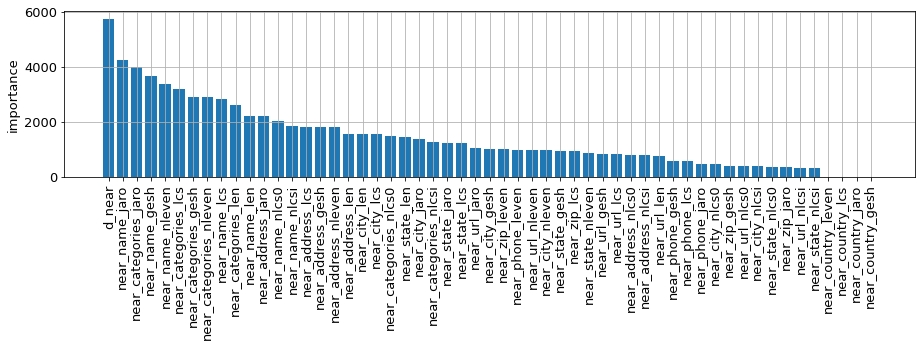

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 16:29:20,946] A new study created in memory with name: no-name-948782c3-1561-4af3-9ae5-29350fba32f3


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:30:30,292] Trial 0 finished with value: 0.7886111077588407 and parameters: {'threshold': 0.14881711030482958}. Best is trial 0 with value: 0.7886111077588407.


CV: 0.788611, precision: 0.910662, recall: 0.863367


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:31:27,993] Trial 1 finished with value: 0.8113248079515211 and parameters: {'threshold': 0.6453578224975782}. Best is trial 1 with value: 0.8113248079515211.


CV: 0.811325, precision: 0.978745, recall: 0.829121


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812136, precision: 0.977117, recall: 0.831326


[I 2022-05-14 16:32:20,239] Trial 2 finished with value: 0.8121363903085046 and parameters: {'threshold': 0.6226545299870333}. Best is trial 2 with value: 0.8121363903085046.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:33:12,163] Trial 3 finished with value: 0.810852253063796 and parameters: {'threshold': 0.6562304224827717}. Best is trial 2 with value: 0.8121363903085046.


CV: 0.810852, precision: 0.979516, recall: 0.828000


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.797810, precision: 0.989473, recall: 0.806550


[I 2022-05-14 16:34:03,562] Trial 4 finished with value: 0.7978095868742323 and parameters: {'threshold': 0.8144820586284864}. Best is trial 2 with value: 0.8121363903085046.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:34:56,954] Trial 5 finished with value: 0.8122797219562372 and parameters: {'threshold': 0.6193040681031005}. Best is trial 5 with value: 0.8122797219562372.


CV: 0.812280, precision: 0.976890, recall: 0.831660


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:35:48,829] Trial 6 finished with value: 0.7970692633476532 and parameters: {'threshold': 0.8193187554971156}. Best is trial 5 with value: 0.8122797219562372.


CV: 0.797069, precision: 0.989728, recall: 0.805589


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:36:56,371] Trial 7 finished with value: 0.760765945550631 and parameters: {'threshold': 0.0659772933474152}. Best is trial 5 with value: 0.8122797219562372.


CV: 0.760766, precision: 0.869289, recall: 0.868229


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:37:48,357] Trial 8 finished with value: 0.8121611514783494 and parameters: {'threshold': 0.6220777203516326}. Best is trial 5 with value: 0.8122797219562372.


CV: 0.812161, precision: 0.977076, recall: 0.831387


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799018, precision: 0.927673, recall: 0.859908


[I 2022-05-14 16:38:49,108] Trial 9 finished with value: 0.7990176486909502 and parameters: {'threshold': 0.2108959961779887}. Best is trial 5 with value: 0.8122797219562372.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.810171, precision: 0.950178, recall: 0.852296


[I 2022-05-14 16:39:48,374] Trial 10 finished with value: 0.8101705873091187 and parameters: {'threshold': 0.3427225035637547}. Best is trial 5 with value: 0.8122797219562372.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:40:44,158] Trial 11 finished with value: 0.8138933439498215 and parameters: {'threshold': 0.47552650525862666}. Best is trial 11 with value: 0.8138933439498215.


CV: 0.813893, precision: 0.964921, recall: 0.843519


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812960, precision: 0.959345, recall: 0.847332


[I 2022-05-14 16:41:42,163] Trial 12 finished with value: 0.8129599233382081 and parameters: {'threshold': 0.4200687466047077}. Best is trial 11 with value: 0.8138933439498215.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:42:39,248] Trial 13 finished with value: 0.812206863474489 and parameters: {'threshold': 0.3892904156752397}. Best is trial 11 with value: 0.8138933439498215.


CV: 0.812207, precision: 0.955988, recall: 0.849402


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813354, precision: 0.961376, recall: 0.846018


[I 2022-05-14 16:43:37,299] Trial 14 finished with value: 0.8133537460258804 and parameters: {'threshold': 0.4394529376000598}. Best is trial 11 with value: 0.8138933439498215.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813910, precision: 0.965436, recall: 0.843100


[I 2022-05-14 16:44:33,570] Trial 15 finished with value: 0.8139095471455262 and parameters: {'threshold': 0.4811472989295424}. Best is trial 15 with value: 0.8139095471455262.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:45:14,642] Trial 16 finished with value: 0.744484188333549 and parameters: {'threshold': 0.9660909840234186}. Best is trial 15 with value: 0.8139095471455262.


CV: 0.744484, precision: 0.997858, recall: 0.746222


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:46:13,713] Trial 17 finished with value: 0.8081951322673662 and parameters: {'threshold': 0.3082480491643368}. Best is trial 15 with value: 0.8139095471455262.


CV: 0.808195, precision: 0.945408, recall: 0.854334


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814003, precision: 0.970011, recall: 0.839282


[I 2022-05-14 16:47:13,259] Trial 18 finished with value: 0.8140034339585769 and parameters: {'threshold': 0.5319952129352434}. Best is trial 18 with value: 0.8140034339585769.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814014, precision: 0.969208, recall: 0.839988


[I 2022-05-14 16:48:08,607] Trial 19 finished with value: 0.8140137756647868 and parameters: {'threshold': 0.5228734973651934}. Best is trial 19 with value: 0.8140137756647868.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:49:07,131] Trial 20 finished with value: 0.8067162912661286 and parameters: {'threshold': 0.28749191126922324}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.806716, precision: 0.942211, recall: 0.855531


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:50:03,440] Trial 21 finished with value: 0.8140070354046485 and parameters: {'threshold': 0.49854182164369165}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.814007, precision: 0.967032, recall: 0.841838


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:50:57,481] Trial 22 finished with value: 0.8138145459216047 and parameters: {'threshold': 0.5468596217658345}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.813815, precision: 0.971243, recall: 0.838031


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:51:47,136] Trial 23 finished with value: 0.8051244121845951 and parameters: {'threshold': 0.7461318996207685}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.805124, precision: 0.985432, recall: 0.817280


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:52:42,401] Trial 24 finished with value: 0.8137678448806726 and parameters: {'threshold': 0.5508970637362902}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.813768, precision: 0.971563, recall: 0.837703


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.806209, precision: 0.984540, recall: 0.819121


[I 2022-05-14 16:53:32,314] Trial 25 finished with value: 0.8062091731040377 and parameters: {'threshold': 0.7321176174617536}. Best is trial 19 with value: 0.8140137756647868.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:54:27,331] Trial 26 finished with value: 0.8138481967157646 and parameters: {'threshold': 0.5445427258605839}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.813848, precision: 0.971043, recall: 0.838233


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:55:25,830] Trial 27 finished with value: 0.8029766626156986 and parameters: {'threshold': 0.2457996386771652}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.802977, precision: 0.934867, recall: 0.857926


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812147, precision: 0.955836, recall: 0.849473


[I 2022-05-14 16:56:24,585] Trial 28 finished with value: 0.8121473769296077 and parameters: {'threshold': 0.38788073640692616}. Best is trial 19 with value: 0.8140137756647868.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.790545, precision: 0.913677, recall: 0.862855


[I 2022-05-14 16:57:26,596] Trial 29 finished with value: 0.7905452957595532 and parameters: {'threshold': 0.15789648785105487}. Best is trial 19 with value: 0.8140137756647868.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.806726, precision: 0.984102, recall: 0.820001


[I 2022-05-14 16:58:20,001] Trial 30 finished with value: 0.8067257451089441 and parameters: {'threshold': 0.7250196800561386}. Best is trial 19 with value: 0.8140137756647868.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:59:15,239] Trial 31 finished with value: 0.8140062710975675 and parameters: {'threshold': 0.4943941311045769}. Best is trial 19 with value: 0.8140137756647868.


CV: 0.814006, precision: 0.966666, recall: 0.842150


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814016, precision: 0.967519, recall: 0.841427


[I 2022-05-14 17:00:10,559] Trial 32 finished with value: 0.8140161528453781 and parameters: {'threshold': 0.5039862733832537}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:01:07,590] Trial 33 finished with value: 0.8139105186038041 and parameters: {'threshold': 0.48063384611710996}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.813911, precision: 0.965393, recall: 0.843137


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:02:01,150] Trial 34 finished with value: 0.8132542181928133 and parameters: {'threshold': 0.583615614206431}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.813254, precision: 0.974213, recall: 0.834942


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.811034, precision: 0.952521, recall: 0.851168


[I 2022-05-14 17:02:58,901] Trial 35 finished with value: 0.8110339677714065 and parameters: {'threshold': 0.3608618756156514}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:03:49,854] Trial 36 finished with value: 0.809760199697679 and parameters: {'threshold': 0.6784255093625045}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.809760, precision: 0.981052, recall: 0.825608


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813153, precision: 0.960252, recall: 0.846750


[I 2022-05-14 17:04:47,980] Trial 37 finished with value: 0.8131530608278156 and parameters: {'threshold': 0.428838034317724}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:05:40,520] Trial 38 finished with value: 0.8130783812376587 and parameters: {'threshold': 0.5919677700773573}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.813078, precision: 0.974876, recall: 0.834201


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.811089, precision: 0.979108, recall: 0.828582


[I 2022-05-14 17:06:33,085] Trial 39 finished with value: 0.8110889051390738 and parameters: {'threshold': 0.6507319692190175}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.738769, precision: 0.838415, recall: 0.870138


[I 2022-05-14 17:07:43,502] Trial 40 finished with value: 0.7387686802851448 and parameters: {'threshold': 0.03670821400364366}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:08:39,551] Trial 41 finished with value: 0.8139700525857876 and parameters: {'threshold': 0.5356104434583985}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.813970, precision: 0.970329, recall: 0.838969


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813970, precision: 0.966340, recall: 0.842390


[I 2022-05-14 17:09:35,162] Trial 42 finished with value: 0.8139699065340215 and parameters: {'threshold': 0.49098878271404195}. Best is trial 32 with value: 0.8140161528453781.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:10:29,770] Trial 43 finished with value: 0.8132316980672435 and parameters: {'threshold': 0.5848714616189782}. Best is trial 32 with value: 0.8140161528453781.


CV: 0.813232, precision: 0.974322, recall: 0.834823


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:11:25,947] Trial 44 finished with value: 0.8140507688402644 and parameters: {'threshold': 0.5116192419448837}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814051, precision: 0.968250, recall: 0.840845


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:12:23,510] Trial 45 finished with value: 0.8131709482895328 and parameters: {'threshold': 0.42992211517856777}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813171, precision: 0.960369, recall: 0.846667


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.809535, precision: 0.981309, recall: 0.825163


[I 2022-05-14 17:13:15,630] Trial 46 finished with value: 0.8095351553870866 and parameters: {'threshold': 0.6823957605129184}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:14:11,561] Trial 47 finished with value: 0.8137254593498608 and parameters: {'threshold': 0.4606323774795869}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813725, precision: 0.963504, recall: 0.844569


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:15:09,944] Trial 48 finished with value: 0.8121351014488561 and parameters: {'threshold': 0.3875756130317106}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.812135, precision: 0.955795, recall: 0.849494


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:16:09,974] Trial 49 finished with value: 0.8093410181410077 and parameters: {'threshold': 0.3273364447326794}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.809341, precision: 0.948130, recall: 0.853196


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812394, precision: 0.976700, recall: 0.831939


[I 2022-05-14 17:17:04,051] Trial 50 finished with value: 0.8123943066997292 and parameters: {'threshold': 0.6165848859924765}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:17:57,625] Trial 51 finished with value: 0.8140394304119015 and parameters: {'threshold': 0.5151990182475641}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814039, precision: 0.968553, recall: 0.840573


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:18:54,498] Trial 52 finished with value: 0.8140320490112567 and parameters: {'threshold': 0.5063135114658368}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814032, precision: 0.967745, recall: 0.841246


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:19:52,625] Trial 53 finished with value: 0.8140370887616117 and parameters: {'threshold': 0.5152082014163295}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814037, precision: 0.968553, recall: 0.840570


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813617, precision: 0.962608, recall: 0.845220


[I 2022-05-14 17:20:49,716] Trial 54 finished with value: 0.8136167753462702 and parameters: {'threshold': 0.4514212361908107}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:21:44,235] Trial 55 finished with value: 0.8140166363917406 and parameters: {'threshold': 0.5208276549410468}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814017, precision: 0.969037, recall: 0.840138


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812980, precision: 0.975192, recall: 0.833828


[I 2022-05-14 17:22:39,127] Trial 56 finished with value: 0.8129797409256931 and parameters: {'threshold': 0.5960766066390487}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812607, precision: 0.957516, recall: 0.848516


[I 2022-05-14 17:23:38,350] Trial 57 finished with value: 0.8126071245212884 and parameters: {'threshold': 0.4030336048084919}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:24:27,014] Trial 58 finished with value: 0.7806409903348425 and parameters: {'threshold': 0.8987389432230055}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.780641, precision: 0.994132, recall: 0.785459


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:25:20,329] Trial 59 finished with value: 0.8119180763637958 and parameters: {'threshold': 0.6298832883333974}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.811918, precision: 0.977685, recall: 0.830617


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813551, precision: 0.973112, recall: 0.836177


[I 2022-05-14 17:26:16,523] Trial 60 finished with value: 0.8135505534255894 and parameters: {'threshold': 0.5694385948943}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814033, precision: 0.968119, recall: 0.840936


[I 2022-05-14 17:27:11,545] Trial 61 finished with value: 0.8140331021181517 and parameters: {'threshold': 0.5102530019963548}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:28:08,807] Trial 62 finished with value: 0.8140415410842617 and parameters: {'threshold': 0.514660929182221}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814042, precision: 0.968508, recall: 0.840611


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814015, precision: 0.969223, recall: 0.839975


[I 2022-05-14 17:29:03,944] Trial 63 finished with value: 0.8140152059820115 and parameters: {'threshold': 0.5230099973924472}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813625, precision: 0.962566, recall: 0.845265


[I 2022-05-14 17:30:01,739] Trial 64 finished with value: 0.8136251720033094 and parameters: {'threshold': 0.4508653350539306}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813631, precision: 0.972187, recall: 0.837036


[I 2022-05-14 17:30:57,515] Trial 65 finished with value: 0.8136309314430047 and parameters: {'threshold': 0.5587543233911584}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:31:57,342] Trial 66 finished with value: 0.8111099550898418 and parameters: {'threshold': 0.36301155258031326}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.811110, precision: 0.952772, recall: 0.851033


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:32:54,989] Trial 67 finished with value: 0.8140376815428023 and parameters: {'threshold': 0.5145236010201323}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814038, precision: 0.968496, recall: 0.840619


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:33:47,558] Trial 68 finished with value: 0.8095731291600412 and parameters: {'threshold': 0.682018375141189}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.809573, precision: 0.981290, recall: 0.825216


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:34:43,975] Trial 69 finished with value: 0.8138810802766693 and parameters: {'threshold': 0.4749243248107607}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813881, precision: 0.964859, recall: 0.843555


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:35:46,606] Trial 70 finished with value: 0.8067983408002938 and parameters: {'threshold': 0.28836378150767483}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.806798, precision: 0.942359, recall: 0.855487


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:36:43,588] Trial 71 finished with value: 0.8139807419786588 and parameters: {'threshold': 0.5288795709681066}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813981, precision: 0.969732, recall: 0.839500


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:37:39,264] Trial 72 finished with value: 0.8140116655988967 and parameters: {'threshold': 0.5018428146052051}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814012, precision: 0.967333, recall: 0.841585


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:38:36,202] Trial 73 finished with value: 0.8127869353188585 and parameters: {'threshold': 0.41012278650500533}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.812787, precision: 0.958306, recall: 0.848034


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:39:33,707] Trial 74 finished with value: 0.8136787951628407 and parameters: {'threshold': 0.5554291019213764}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813679, precision: 0.971916, recall: 0.837315


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:40:29,818] Trial 75 finished with value: 0.8140390414294892 and parameters: {'threshold': 0.5129384818871369}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814039, precision: 0.968360, recall: 0.840736


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:41:23,392] Trial 76 finished with value: 0.8125237653089064 and parameters: {'threshold': 0.6123916649985889}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.812524, precision: 0.976388, recall: 0.832338


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:42:19,717] Trial 77 finished with value: 0.8138194677225218 and parameters: {'threshold': 0.47055305403041614}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813819, precision: 0.964445, recall: 0.843852


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:43:17,022] Trial 78 finished with value: 0.8140377594878316 and parameters: {'threshold': 0.5141440007341807}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814038, precision: 0.968469, recall: 0.840643


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:44:13,209] Trial 79 finished with value: 0.8132130430318479 and parameters: {'threshold': 0.4327768540026}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813213, precision: 0.960658, recall: 0.846474


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813584, precision: 0.973017, recall: 0.836287


[I 2022-05-14 17:45:07,773] Trial 80 finished with value: 0.813584109282461 and parameters: {'threshold': 0.5681512297978286}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:46:03,222] Trial 81 finished with value: 0.8140231210298042 and parameters: {'threshold': 0.5188189281891298}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814023, precision: 0.968868, recall: 0.840292


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:46:59,613] Trial 82 finished with value: 0.8138559686313861 and parameters: {'threshold': 0.4736452256224173}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813856, precision: 0.964744, recall: 0.843632


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:47:55,492] Trial 83 finished with value: 0.8140215689801878 and parameters: {'threshold': 0.4977980982318517}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814022, precision: 0.966969, recall: 0.841904


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813883, precision: 0.970976, recall: 0.838324


[I 2022-05-14 17:48:49,621] Trial 84 finished with value: 0.8138825940062684 and parameters: {'threshold': 0.5436253666784537}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812907, precision: 0.975373, recall: 0.833599


[I 2022-05-14 17:49:44,522] Trial 85 finished with value: 0.8129065654356648 and parameters: {'threshold': 0.5986103582125459}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.811825, precision: 0.977780, recall: 0.830443


[I 2022-05-14 17:50:37,583] Trial 86 finished with value: 0.8118253342831836 and parameters: {'threshold': 0.6315188779396572}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813624, precision: 0.962660, recall: 0.845185


[I 2022-05-14 17:51:33,269] Trial 87 finished with value: 0.813624233446574 and parameters: {'threshold': 0.45196484489842387}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.811485, precision: 0.953814, recall: 0.850530


[I 2022-05-14 17:52:30,224] Trial 88 finished with value: 0.811484600741431 and parameters: {'threshold': 0.3712762604117589}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:53:25,964] Trial 89 finished with value: 0.8140222792635097 and parameters: {'threshold': 0.5084168622143035}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814022, precision: 0.967933, recall: 0.841078


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813368, precision: 0.973724, recall: 0.835470


[I 2022-05-14 17:54:21,429] Trial 90 finished with value: 0.813367576597168 and parameters: {'threshold': 0.5772182255718465}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:55:17,761] Trial 91 finished with value: 0.81401458013008 and parameters: {'threshold': 0.5207824381814384}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.814015, precision: 0.969030, recall: 0.840142


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:56:12,761] Trial 92 finished with value: 0.8139388057057282 and parameters: {'threshold': 0.5410058504184012}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813939, precision: 0.970775, recall: 0.838554


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:57:09,927] Trial 93 finished with value: 0.8139378307668582 and parameters: {'threshold': 0.4871773350931023}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813938, precision: 0.965984, recall: 0.842662


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:58:08,923] Trial 94 finished with value: 0.8131359855936957 and parameters: {'threshold': 0.4282615093599741}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813136, precision: 0.960184, recall: 0.846791


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.810945, precision: 0.979372, recall: 0.828213


[I 2022-05-14 17:59:01,252] Trial 95 finished with value: 0.8109454849504334 and parameters: {'threshold': 0.6543733835017473}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814034, precision: 0.968168, recall: 0.840895


[I 2022-05-14 17:59:58,676] Trial 96 finished with value: 0.8140335882006979 and parameters: {'threshold': 0.5108625561135491}. Best is trial 44 with value: 0.8140507688402644.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 18:00:54,522] Trial 97 finished with value: 0.8137754918224198 and parameters: {'threshold': 0.4641514954210118}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813775, precision: 0.963861, recall: 0.844314


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 18:01:49,282] Trial 98 finished with value: 0.8137587290286856 and parameters: {'threshold': 0.5516858617083388}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.813759, precision: 0.971627, recall: 0.837637


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 18:02:46,409] Trial 99 finished with value: 0.8124316633689124 and parameters: {'threshold': 0.3971581035183144}. Best is trial 44 with value: 0.8140507688402644.


CV: 0.812432, precision: 0.956844, recall: 0.848898


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5116192419448837

In [ ]:
study.best_value

0.8140507688402644

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.814051, precision: 0.968250, recall: 0.840845


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
test["max_pred"] = test["id"].map(dict(test.groupby("id")["pred"].max()))

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[(test["pred"] == test["max_pred"]) & (test["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
